In [ ]:
%matplotlib widget
import numpy as np

theta = np.pi/6
phi = np.pi/3
euler = np.array([theta, phi, 0.0])

rotmat = np.array([[0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [-1.0, 0.0, 0.0]])

# visualize rotation matrix
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(0, 0, 0, rotmat[0, 0], rotmat[0, 1], rotmat[0, 2], color='r')
ax.quiver(0, 0, 0, rotmat[1, 0], rotmat[1, 1], rotmat[1, 2], color='g')
ax.quiver(0, 0, 0, rotmat[2, 0], rotmat[2, 1], rotmat[2, 2], color='b')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

In [ ]:
import torch
import numpy as np
def rpy2rotmat(rpy: torch.Tensor) -> torch.Tensor:
    # convert roll-pitch-yaw to rotation matrix with torch
    # rpy: (batch_size, 3)
    # rotmat: (batch_size, 3, 3)
    roll, pitch, yaw = rpy[:, 0], rpy[:, 1], rpy[:, 2]
    rotmat = torch.zeros(rpy.shape[0], 3, 3, device=rpy.device)
    rotmat[:, 0, 0] = torch.cos(yaw) * torch.cos(pitch)
    rotmat[:, 0, 1] = torch.cos(yaw) * torch.sin(pitch) * torch.sin(roll) - torch.sin(yaw) * torch.cos(roll)
    rotmat[:, 0, 2] = torch.cos(yaw) * torch.sin(pitch) * torch.cos(roll) + torch.sin(yaw) * torch.sin(roll)
    rotmat[:, 1, 0] = torch.sin(yaw) * torch.cos(pitch)
    rotmat[:, 1, 1] = torch.sin(yaw) * torch.sin(pitch) * torch.sin(roll) + torch.cos(yaw) * torch.cos(roll)
    rotmat[:, 1, 2] = torch.sin(yaw) * torch.sin(pitch) * torch.cos(roll) - torch.cos(yaw) * torch.sin(roll)
    rotmat[:, 2, 0] = -torch.sin(pitch)
    rotmat[:, 2, 1] = torch.cos(pitch) * torch.sin(roll)
    rotmat[:, 2, 2] = torch.cos(pitch) * torch.cos(roll)
    return rotmat

In [ ]:
angle = 0.0
euler = np.array([angle, 0.0, 0.0])
rpy = torch.tensor(euler).unsqueeze(0)
rotmat = rpy2rotmat(rpy)

In [ ]:
force = torch.tensor([0.0, 0.0, 1.0])
(rotmat[0]@force)[2] - np.cos(angle)

In [ ]:
import torch
from adaptive_control_gym.utils import geom
import matplotlib.pyplot as plt
import numpy as np

quat_drones = torch.tensor([0.0, 0.0, 0.0, 1.0])
sim_dt = 1e-4
vrpy_drones = torch.ones(3)*10
vrpy_drones[2] = 0.0

# integrate the for 1000 steps and visualize the result
quat_list = []
rpy_list = []
for i in range(1000):
    quat_drones = geom.integrate_quat(quat_drones, vrpy_drones, sim_dt)
    quat_list.append(quat_drones.numpy())
    rpy_list.append(geom.quat2rpy(quat_drones).numpy())

# plot results in 2 subplots
quat_list = np.array(quat_list)
rpy_list = np.array(rpy_list)
fig, axes = plt.subplots(2, 1, figsize=(5, 5))
axes[0].plot(quat_list[:, 0], label='x')
axes[0].plot(quat_list[:, 1], label='y')
axes[0].plot(quat_list[:, 2], label='z')
axes[0].plot(quat_list[:, 3], label='w')
axes[0].legend()
axes[1].plot(rpy_list[:, 0], label='roll')
axes[1].plot(rpy_list[:, 1], label='pitch')
axes[1].plot(rpy_list[:, 2], label='yaw')
axes[1].legend()


In [ ]:
quat = torch.tensor([[ 0.0445,  0.7057, -0.0445,  0.7057]])
quat = torch.load('/home/pcy/rl/policy-adaptation-survey/adaptive_control_gym/envs/results/error_tensor_1683287126.5533292.pt')
geom.quat2rpy(quat), quat

np.arccos(quat[0,3].item())*2, np.pi/3

In [ ]:
import jax.numpy as jnp
import jax
from jax.random import PRNGKey, uniform
import matplotlib.pyplot as plt

def generate_points(num_points=6):
    points = jnp.zeros((num_points, 2))
    key = PRNGKey(3)

    # Sample the first point uniformly from [-1.5, 1.5]
    key, subkey = jax.random.split(key)
    y = uniform(subkey, minval=-1.5, maxval=1.5)
    key, subkey = jax.random.split(key)
    z = uniform(subkey, minval=-1.5, maxval=1.5)
    points = points.at[0].set(jnp.array([y, z]))

    for i in range(1, num_points):
        # Calculate the previous point angle to the center
        prev_angle = jnp.arctan2(points[i-1, 1], points[i-1, 0]) + jnp.pi

        # Sample a random displacement angle from [-pi/4, pi/4]
        key, subkey = jax.random.split(key)
        delta_angle = uniform(subkey, minval=-jnp.pi/3, maxval=jnp.pi/3)

        # Calculate the new angle
        angle = prev_angle + delta_angle

        # Sample the distance from [1.5, 2.5]
        key, subkey = jax.random.split(key)
        distance = uniform(subkey, minval=1.5, maxval=2.5)

        # Calculate the new point
        y = points[i-1, 0] + distance * jnp.cos(angle)
        z = points[i-1, 1] + distance * jnp.sin(angle)
        points = points.at[i].set(jnp.array([y, z]))

    return points

points = generate_points()

# Create the plot
plt.figure()
for i in range(6):
    plt.scatter(points[i, 0], points[i, 1], marker='o', label=f'{i}')
    # plot arrow from previous point to current point
    if i > 0:
        plt.arrow(points[i-1, 0], points[i-1, 1], points[i, 0] - points[i-1, 0], points[i, 1] - points[i-1, 1], 
                  color='black', width=0.01, head_width=0.05, length_includes_head=True, alpha=i / 6)
plt.legend()
plt.scatter(0, 0, marker='x', color='red', label='Center')

# Add labels and legend
plt.xlabel('y')
plt.ylabel('z')
plt.title('Random Points in 2D y-z Space')
plt.legend()

# Set equal aspect ratio and display the ploxwt
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

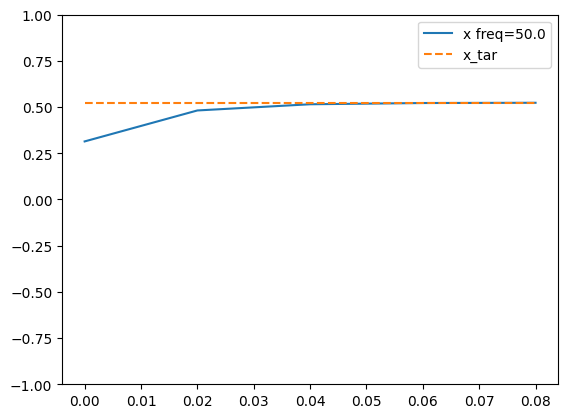

In [33]:
import numpy as np
from matplotlib import pyplot as plt

# simulate pid results
dt = 0.02
substeps_list = [1]

for substeps in substeps_list:
    tau = dt / substeps

    # pid parameters
    kp, ki, kd = 40.0, 0.0, 0.0
    integral = 0.0
    last_error = 0.0

    # run pid controller
    x = -np.pi/6
    x_tar = np.pi/6
    v = 0.0

    x_list = []
    v_list = []
    t_list = []
    for i in range(int(0.1//tau)):
        error = x_tar - x
        integral += error * tau
        derivative = (error - last_error) / tau
        last_error = error
        v = kp * error + ki * integral + kd * derivative
        x += v * tau
        x_list.append(x)
        v_list.append(v)
        t_list.append(i * tau)

    # plot results
    plt.plot(t_list, x_list, label=f'x freq={1/tau:.1f}')
plt.plot(t_list, [x_tar]*len(t_list), label='x_tar', linestyle='--')
plt.ylim([-1.0, 1.0])
plt.legend()

In [6]:
import sympy as sp
from sympy.physics.mechanics import dynamicsymbols

t = sp.Symbol("t")
phi_rope = dynamicsymbols("phi_rope")
theta_rope = dynamicsymbols("theta_rope")
zeta = sp.Matrix([sp.sin(theta_rope) * sp.cos(phi_rope),
                     sp.sin(theta_rope) * sp.sin(phi_rope), sp.cos(theta_rope)])

In [9]:
print(sp.diff(zeta, (t, 2)))

Matrix([[-sin(phi_rope(t))*sin(theta_rope(t))*Derivative(phi_rope(t), (t, 2)) - 2*sin(phi_rope(t))*cos(theta_rope(t))*Derivative(phi_rope(t), t)*Derivative(theta_rope(t), t) - sin(theta_rope(t))*cos(phi_rope(t))*Derivative(phi_rope(t), t)**2 - sin(theta_rope(t))*cos(phi_rope(t))*Derivative(theta_rope(t), t)**2 + cos(phi_rope(t))*cos(theta_rope(t))*Derivative(theta_rope(t), (t, 2))], [-sin(phi_rope(t))*sin(theta_rope(t))*Derivative(phi_rope(t), t)**2 - sin(phi_rope(t))*sin(theta_rope(t))*Derivative(theta_rope(t), t)**2 + sin(phi_rope(t))*cos(theta_rope(t))*Derivative(theta_rope(t), (t, 2)) + sin(theta_rope(t))*cos(phi_rope(t))*Derivative(phi_rope(t), (t, 2)) + 2*cos(phi_rope(t))*cos(theta_rope(t))*Derivative(phi_rope(t), t)*Derivative(theta_rope(t), t)], [-(sin(theta_rope(t))*Derivative(theta_rope(t), (t, 2)) + cos(theta_rope(t))*Derivative(theta_rope(t), t)**2)]])
